# TIMESERIES FORECASTING - Autoregressive Integrated Moving Average (ARIMA)


## Install and import libraries


In [5]:
import pandas as pd
import numpy as np
from scipy import stats                                 # needed for z-score
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

## Load and prepare data
---

In [6]:
df = pd.read_csv('./airpassengers.csv', parse_dates=['Month'], index_col=['Month'])

## Plot data
---

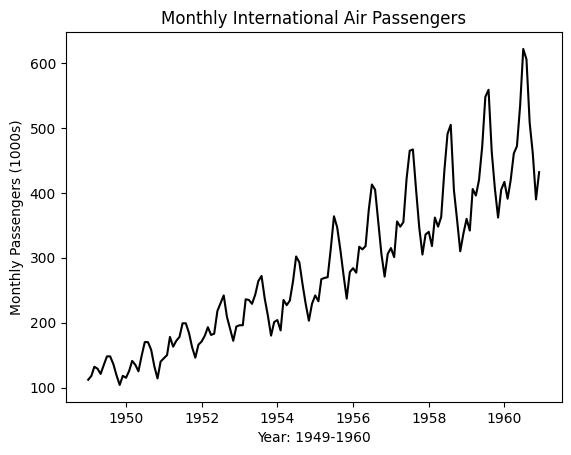

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Split data into train and test set
---

### Creating Training Dataset

In [8]:
# Select data from before 1958.

train = df.loc[df.index < '1958-01-01']


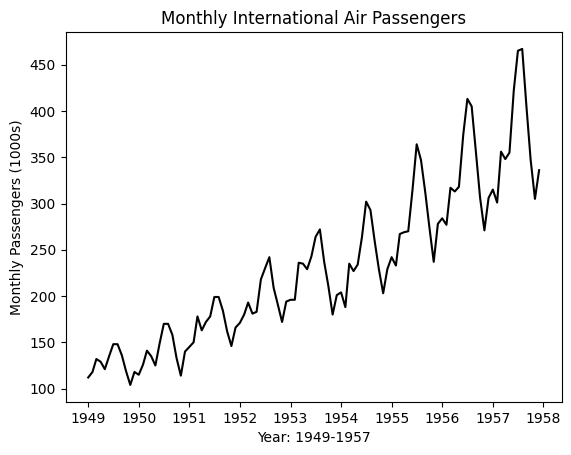

In [9]:
# Plot the training data

fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(train, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Create Testing Dataset

In [10]:
# Use data from 1958 through 1960 (the last three years) for testing.

test = df.loc[df.index >= '1958-01-01']

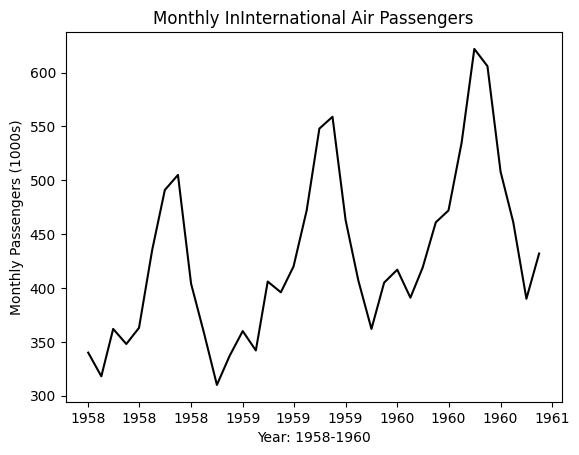

In [11]:
# Plot the testing data.
# Note that the vertical scale changes from the previous graph.

fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly InInternational Air Passengers')
plt.plot(test, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Prepare the model
---

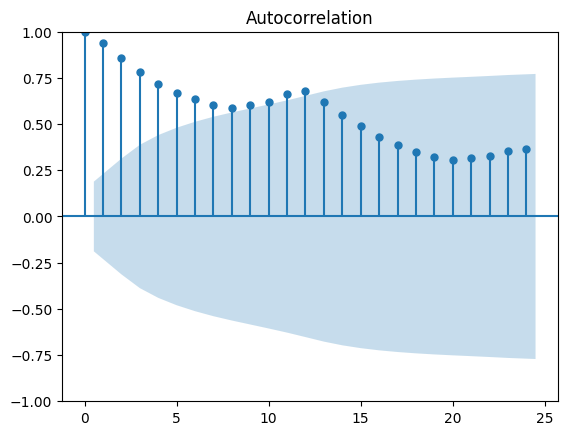

In [12]:
# Test Stationarity
train_acf = plot_acf(train, lags=24)

### Linear Model

In [13]:
lr = sm.OLS(endog=train['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + train.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           6.40e-43
Time:                        11:35:02   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [14]:
# Extract the fitted values.
y_hat = lr.fittedvalues

In [15]:
# Extract the 95% prediction interval.
y_ci = lr.get_prediction().conf_int(alpha=0.05)

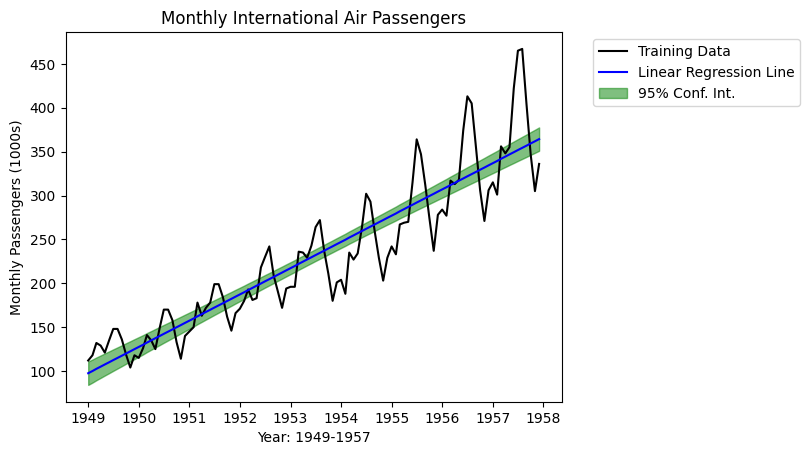

In [16]:
# Graph time series with linear regression line and corresponding 95% confidence interval.
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(train, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='green', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## ARIMA: Train model
---

In [17]:
auto_arima_model = auto_arima(train, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Thu, 09 Nov 2023   AIC                            704.001
Time:                                    11:35:04   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

In [18]:
# Extract the residuals. 
resid = auto_arima_model.resid()

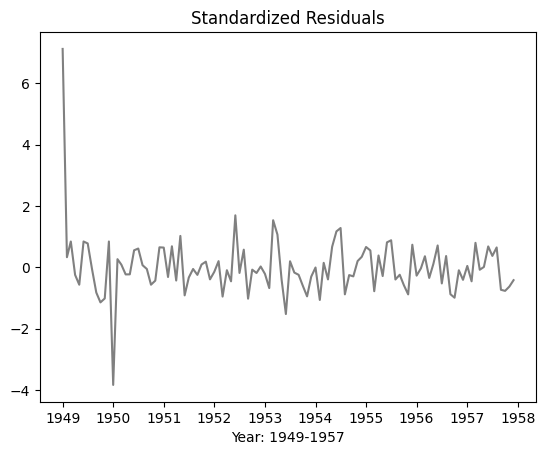

In [19]:
# Plot the standardized residuals.
fig, ax = plt.subplots()
plt.plot(train.index, stats.zscore(resid), color='gray') 
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

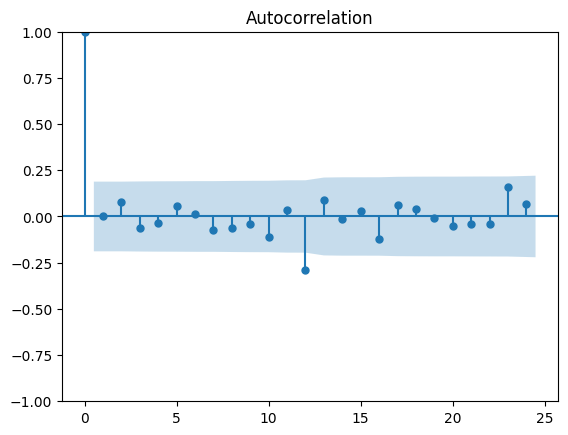

In [20]:
# Plot the ACF (autocorrelation function) of the residuals. 
res_acf = plot_acf(resid, lags=24)

## Test the model
---

In [21]:
# Fit the best model to the training data.
auto_arima_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [22]:
# Use the model to predict intervals for last three years.
# That is, apply the model to the testing dataset.
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

In [23]:
# Extract the time series of model predictions.
y_pred = pd.Series(arima_predictions[0], index=test.index)


In [24]:
# Extract the 95% prediction interval.
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

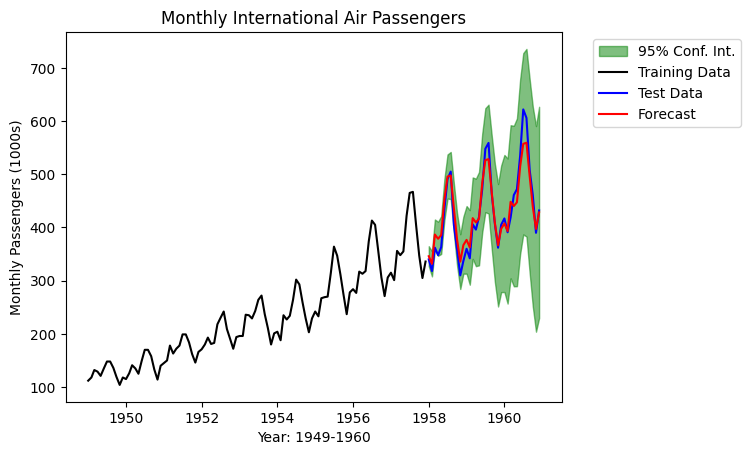

In [25]:
# Graph the training data (1949-1957).
# Add the predictions for the testing data (1958-1960).
# Add observed values from testing data.

fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.fill_between(test.index, y_pred_lb, y_pred_ub, color='green', alpha=0.5, label='95% Conf. Int.')
plt.plot(train, color='black', label='Training Data')
plt.plot(test, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [26]:
# Create a dataframe with the observed values for the testing dataset.
# Add the predictions from the ARIMA model.
# Add the low and high boundaries for the 95% confidence intervals.

test_pred = pd.DataFrame({
    'Actual': test.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=test.index)

In [27]:
test_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515741,415.060243
1958-04-01,348,378.774472,346.695455,410.853490
1958-05-01,363,385.777732,350.270765,421.284699
